In [90]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [159]:
grid_size = 25
grid = np.zeros((grid_size, grid_size))

start = (0, 0)
end = (grid_size - 1, grid_size - 1)

grid[start] = 1 
grid[end] = 2

num_obstacles = int(grid_size * grid_size * 0.3) #30% obstacles
for _ in range(num_obstacles):
    obstacle = (random.randint(0, grid_size - 1), random.randint(0, grid_size - 1))
    if obstacle != start and obstacle != end:
        grid[obstacle] = -1

Text(24, 24, 'E')

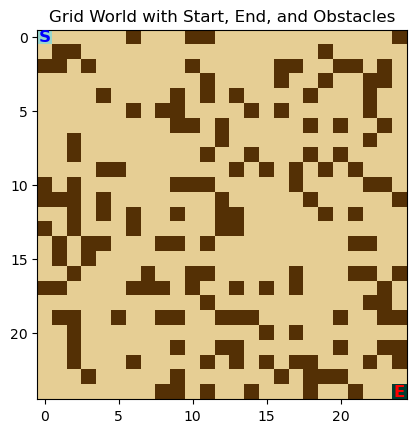

In [160]:
plt.imshow(grid, cmap="BrBG")
plt.title("Grid World with Start, End, and Obstacles")
# # Draw circles around start and end points
# plt.plot(start[1], start[0], 'o', markersize=120, markeredgecolor="blue", markerfacecolor="none", label="Start")
# plt.plot(end[1], end[0], 'o', markersize=120, markeredgecolor="red", markerfacecolor="none", label="End")
plt.text(start[1], start[0], 'S', ha='center', va='center', color="blue", fontsize=12, fontweight='bold')
plt.text(end[1], end[0], 'E', ha='center', va='center', color="red", fontsize=12, fontweight='bold')

In [161]:
actions = {
    'up': (-1, 0),
    'down': (1, 0),
    'left': (0, -1),
    'right': (0, 1)
}

def get_reward(state):
    if state == end:
        return 100
    elif grid[state] == -1:
        return -200
    else:
        return -1

def transition(state, action):
    slip_prob = 0.2
    main_action = actions[action]
    
    outcomes = [main_action]
    if action in ['up', 'down']:
        outcomes += [actions['left'], actions['right']]
    else:
        outcomes += [actions['up'], actions['down']]
    
    next_action = random.choices(outcomes, weights=[1 - slip_prob] + [slip_prob / 2] * 2)[0]
    
    next_state = (state[0] + next_action[0], state[1] + next_action[1])
    if 0 <= next_state[0] < grid_size and 0 <= next_state[1] < grid_size:
        if grid[next_state] != -1:
            return next_state
    return state

Iterations: 100%|████████████████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 246.28it/s]


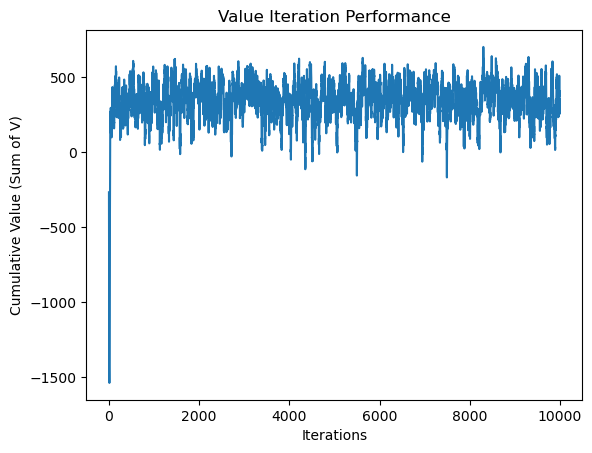

In [167]:
# Value Iteration
def value_iteration(V, gamma=0.9, theta=1e-6, max_iterations=10000):
    iteration = 0
    performance = []  # Track learning speed

    # Progress bar using tqdm for tracking iterations
    with tqdm(total=max_iterations, desc="Iterations") as pbar:
        while iteration < max_iterations:
            delta = 0
            for i in range(grid_size):
                for j in range(grid_size):
                    if (i, j) == end or grid[i, j] == -1:
                        continue
                    
                    v = V[i, j]
                    action_values = {}
                    for action in actions:
                        next_state = transition((i, j), action)
                        action_values[action] = get_reward(next_state) + gamma * V[next_state]
                    
                    V[i, j] = max(action_values.values())  # Bellman backup step
                    delta = max(delta, abs(v - V[i, j]))
            
            performance.append(np.sum(V))  # Track total value to monitor convergence
            
            # Check for convergence
            if delta < theta:
                break
            iteration += 1
            pbar.update(1)  # Update the progress bar

    return V, performance

# Initialize the value function (all zeros initially)
V = np.zeros((grid_size, grid_size))

# Run value iteration
gamma = 0.9  # Discount factor
V, performance = value_iteration(V, gamma)

# Plot performance (learning curve)
plt.plot(performance)
plt.xlabel("Iterations")
plt.ylabel("Cumulative Value (Sum of V)")
plt.title("Value Iteration Performance")
plt.show()

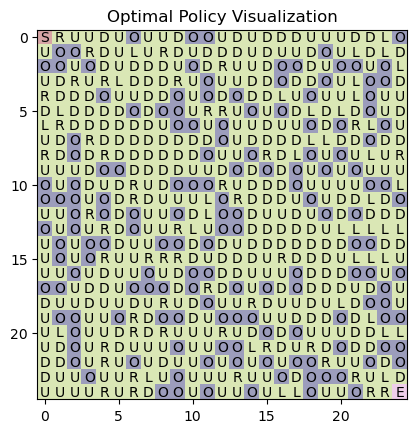

In [163]:
optimal_policy = np.full((grid_size, grid_size), '', dtype=object)
for i in range(grid_size):
    for j in range(grid_size):
        if grid[i, j] == -1:
            optimal_policy[i, j] = "O"
        elif (i, j) == start:
            optimal_policy[i, j] = "S"
        elif (i, j) == end:
            optimal_policy[i, j] = "E"
        else:
            action_values = {}
            for action in actions:
                next_state = transition((i, j), action)
                action_values[action] = get_reward(next_state) + gamma * V[next_state]
            best_action = max(action_values, key=action_values.get)
            optimal_policy[i, j] = best_action[0].upper()  # Using first letter of action

# Visualize the optimal policy
plt.imshow(grid, cmap="tab20b", alpha=0.5)
for i in range(grid_size):
    for j in range(grid_size):
        plt.text(j, i, optimal_policy[i, j], ha="center", va="center", color="black")
plt.title("Optimal Policy Visualization")
plt.show()

# QLearning

In [164]:
# Q-Learning parameters
gamma = 0.9  # Discount factor
alpha = 0.1  # Learning rate
epsilon = 0.1  # Exploration rate

# Initialize Q-table
Q = np.zeros((grid_size, grid_size, len(actions)))

# Q-Learning function
def q_learning(episodes=5000):
    for episode in tqdm(range(episodes)):
        state = start
        done = False

        while not done:
            # Choose action using epsilon-greedy policy
            if random.uniform(0, 1) < epsilon:
                action = random.choice(list(actions.keys()))
            else:
                action = list(actions.keys())[np.argmax(Q[state[0], state[1]])]
            
            # Get next state and reward
            next_state = transition(state, action)
            reward = get_reward(next_state)
            
            # Update Q-value using the Bellman equation
            best_next_action = np.argmax(Q[next_state[0], next_state[1]])
            Q[state[0], state[1], list(actions.keys()).index(action)] += alpha * (
                reward + gamma * Q[next_state[0], next_state[1], best_next_action] - 
                Q[state[0], state[1], list(actions.keys()).index(action)]
            )
            
            state = next_state
            if state == end:
                done = True

# Run Q-learning
q_learning()
print("Training complete!")

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1101.07it/s]

Training complete!


In [165]:
# Extract optimal policy
policy = np.zeros((grid_size, grid_size), dtype=str)

for i in range(grid_size):
    for j in range(grid_size):
        best_action_index = np.argmax(Q[i, j])
        best_action = list(actions.keys())[best_action_index]
        policy[i, j] = best_action if grid[i, j] != -1 else 'O'  # 'O' for obstacles

# Display the start, end, and policy directions
policy[start] = 'S'
policy[end] = 'E'

# plot policy

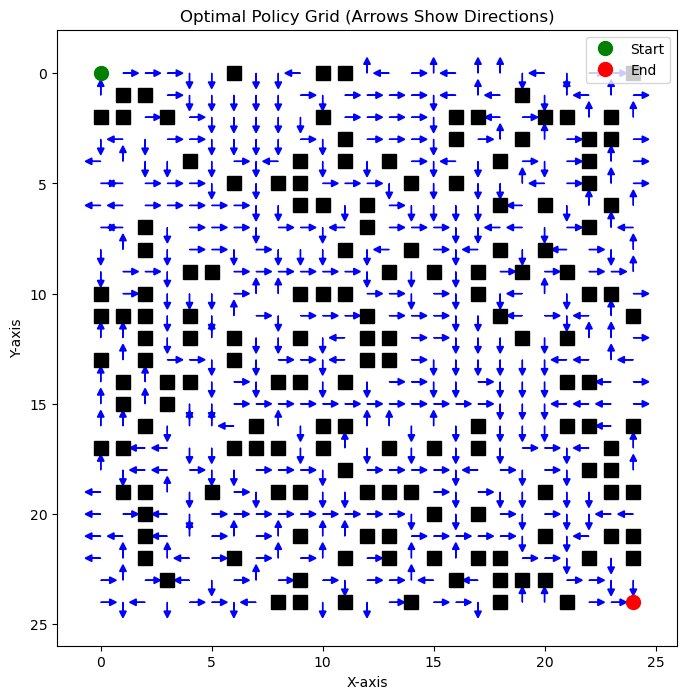

In [166]:
# Define directions for arrows
# policy = optimal_policy
action_vectors = {
    'u': (0, -0.4),  # up
    'd': (0, 0.4),   # down
    'r': (0.4, 0),   # right
    'l': (-0.4, 0)   # left
}

# Create a plot for the policy grid
plt.figure(figsize=(8, 8))

# Plot each cell according to the policy
for i in range(policy.shape[0]):
    for j in range(policy.shape[1]):
        action = policy[i, j]
        if action == 'S':
            plt.plot(j, i, 'go', markersize=10, label="Start" if i + j == 0 else "")  # Start point
        elif action == 'E':
            plt.plot(j, i, 'ro', markersize=10, label="End")  # End point
        elif action == 'O':
            plt.plot(j, i, 'ks', markersize=10, label="Obstacle" if i + j == 1 else "")  # Obstacle
        elif action in action_vectors:
            dx, dy = action_vectors[action]
            plt.arrow(j, i, dx, dy, head_width=0.3, head_length=0.3, fc="blue", ec="blue")

# Add labels and title
plt.gca().invert_yaxis()
plt.grid(False)
plt.legend(loc="upper right")
plt.title("Optimal Policy Grid (Arrows Show Directions)")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()